# Integrador btv

## Importo librerías y defino funciones útiles

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
Borradores = '/content/drive/MyDrive/Borradores_resubmit_sueños'

In [ ]:
# para hacer varios files con nombres que terminen en un indice,
# hacer un lazo con un indice, ej. lazo
# plt.savefig('/content/drive/MyDrive/Borradores_resubmit_sueños/sonograma_{}.jpeg'.format(lazo))

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
import tqdm
import pandas as pd
from scipy.interpolate import interp1d
from scipy import signal
import scipy
from scipy.signal import butter, savgol_filter
from IPython.display import Audio
from scipy.signal import chirp


def butter_lowpass(fs, lcutoff=3000.0, order=15):
    nyq = 0.5*fs
    normal_lcutoff = lcutoff/nyq
    bl, al = butter(order, normal_lcutoff, btype='low', analog=False)
    return bl, al


def butter_lowpass_filter(data, fs, lcutoff=3000.0, order=6):
    bl, al = butter_lowpass(fs, lcutoff, order=order)
    yl = signal.filtfilt(bl, al, data)
    return yl


def butter_highpass(fs, hcutoff=100.0, order=6):
    nyq = 0.5*fs
    normal_hcutoff = hcutoff/nyq
    bh, ah = butter(order, normal_hcutoff, btype='high', analog=False)
    return bh, ah


def butter_highpass_filter(data, fs, hcutoff=100.0, order=5):
    bh, ah = butter_highpass(fs, hcutoff, order=order)
    yh = signal.filtfilt(bh, ah, data)
    return yh


def get_spectrogram(data, sampling_rate, window=1024, overlap=1/1.1,
                    sigma=102.4, plot=False, fmax=8000, drange=6):
    fu, tu, Sxx = signal.spectrogram(data, sampling_rate, nperseg=window,
                                     noverlap=window*overlap,
                                     window=signal.get_window
                                     (('gaussian', sigma), window),
                                     scaling='spectrum')
    Sxx = np.clip(Sxx, a_min=np.amax(Sxx)/10**drange, a_max=np.amax(Sxx))
    if plot:
        plt.figure()
        plt.pcolormesh(tu, fu, np.log(Sxx), cmap=plt.get_cmap('Greys'),
                       rasterized=True)
        plt.ylim(0, fmax)
    return fu, tu, Sxx


def sigmoid(x, x0, a):
    return 1/(1+np.exp(a*(x-x0)))


def signalFilter(vsData, fs, lcutoff=3000, hcutoff=100):
    filt = butter_lowpass_filter(vsData, fs, order=5,
                                           lcutoff=lcutoff)
    filt = butter_highpass_filter(filt, fs, order=5, hcutoff=hcutoff)
    return filt


def s_preprocess(s_raw, fs, signal='vs', env_method='hilbert',
                 ret_filt=False, f_corte=None, normalize=False):
    if signal == 'vs':
        s_filt = signalFilter(s_raw, fs)
        if f_corte is None:
            f_corte = 200
    else:
        s_filt = signalFilter(s_raw, fs, lcutoff=15000, hcutoff=100)
        if f_corte is None:
            f_corte = 100
    if env_method == 'hilbert':
        s_env = envelope_hilbert(s_filt, fs, f_corte=f_corte)
    if normalize:
        factor = np.max(np.abs(s_filt))
        s_filt /= factor
        s_env /= factor
    if ret_filt:
        return s_env, s_filt
    else:
        return s_env


def envelope_hilbert(data, fs=44150, f_corte=100., pow2pad=True):
    n_pad = 0
    n_dat = len(data)
    if pow2pad and not checkIfPow2(n_dat):
        n_pad = n_pad_Pow2(data)
    elif len(data) % 2 == 1:
        n_pad = 1
    envelope = np.abs(signal.hilbert(data, n_dat+n_pad))
    envelope = butter_lowpass_filter(envelope, fs, order=5, lcutoff=f_corte)
    if n_pad > 0:
        envelope = envelope[:-n_pad]
    return envelope


def NextPowerOfTwo(number):
    return int(np.ceil(np.log2(number)))


def n_pad_Pow2(arr):
    nextPower = NextPowerOfTwo(len(arr))
    deficit = int(np.power(2, nextPower) - len(arr))
    return deficit


def checkIfPow2(n):
    return bool(n and not (n & (n-1)))



## Integrador RK4

In [ ]:
def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


## 2 Takens $(\alpha_1, \alpha_2, \beta_1, \beta_2)$

In [ ]:
def dxdt_tbac(z, t, gamma, alfa1, beta1, alfa2, beta2, a):
    x1, y1, x2, y2 = z
    dx1dt = y1
    dy1dt = (alfa1*gamma**2 + beta1*gamma**2*x1 - gamma**2*x1**3 - gamma*x1**2*y1 +
             gamma**2*x1**2 - gamma*x1*y1 - gamma**2*a*(x1-x2))
    dx2dt = y2
    dy2dt = (alfa2*gamma**2 + beta2*gamma**2*x2 - gamma**2*x2**3 - gamma*x2**2*y2 +
             gamma**2*x2**2 - gamma*x2*y2 - gamma**2*a*(x2-x1))
    return dx1dt, dy1dt, dx2dt, dy2dt


## Caso 1: Lockea con forzante diurno - no lockea con nocturno

Ojo, revisar parametros (a, Af) / lockee (y ver rango de frecuencias)

### Cargo $(\alpha, \beta)$

In [ ]:
df = pd.read_csv('https://github.com/jfdoppler/data_tb_synth/raw/main/alfa_s_10000.csv')
t = np.array(df.t)
dt = t[1]-t[0]
fs = 1/dt
alfa = np.array(df.alfa)
beta = np.array(df.beta)
freq = np.array(df.freq)
#beta

In [ ]:
gamma = 10000

In [ ]:
import pandas as pd

In [ ]:
#df_rev = pd.read_csv('https://github.com/jfdoppler/data_tb_synth/raw/main/stats_rev.csv', sep=';')
df_rev = pd.read_csv('/content/drive/MyDrive/Borradores_resubmit_sueños/analisis_dia_db.txt')
#df_rev = df_rev[df_rev['tipo'] == 'burst']
#df_rev['i_vs_rel'] = df_rev.inicio-df_rev.inicio_s
df = df_rev[['duracion', 'frecuencia']]
corr = df.corr()
corr_red = corr.iloc[:, ::-1].iloc[:-1, :-1]

In [ ]:
df_rev.shape[0]

95

generemos los archivos de sonido del canto

In [ ]:
def dxdt_helm(X, t, p, gamma_h, w_h, alpha):
    z = X[0]
    y = X[1]
    return [y, -gamma_h**2*w_h**2*z - 2*alpha*gamma_h*y - gamma_h**2*p]

In [ ]:
def env_slow(data, fs, dt=0.01, kind='cubic'):
    t = np.arange(0, len(data))/fs
    max_sup, _ = signal.find_peaks(np.abs(data), distance=int(fs*dt))
    env_sup = interp1d(t[max_sup], np.abs(data[max_sup]),
                       fill_value='extrapolate',
                       kind=kind)(t)
    return env_sup

In [ ]:
for i in range(0,df_rev.shape[0]):
  duracion_emg = df_rev['duracion'][i]
  new_dur = 0.013287629409107424 + 0.87181677*duracion_emg
  inicio = np.where(np.diff(alfa) != 0)[0][0]
  fin = np.where(np.diff(alfa) != 0)[0][-1]
  duracion = (fin-inicio)*dt
  n_points = int(new_dur//dt)

  alfafunc = interp1d(np.linspace(0, 1, fin-inicio), alfa[inicio:fin], fill_value='extrapolate')
  new_alfa = alfafunc(np.linspace(0, 1, n_points))
  alfa_0 = np.concatenate(([0.05]*int(0.2/dt), new_alfa, [0.05]*int(0.2/dt)))
  alfat = np.zeros_like(alfa_0)
  t = np.arange(0, len(alfat))*dt

  fffunc = interp1d(np.linspace(0, 1, fin-inicio), freq[inicio:fin], fill_value='extrapolate')
  n_points = int(new_dur//dt)
  new_ff = fffunc(np.linspace(0, 1, n_points))
  freq_rs = np.concatenate(([400]*int(0.2/dt), new_ff, [400]*int(0.2/dt)))

  betat = np.zeros_like(alfat) + np.min(beta)

  off = np.where(alfat == np.min(alfat))[0][-1]
  sm_on = sigmoid(t, 0.2 + np.min(t), -400)
  sm_off = sigmoid(t, 0.2 + new_dur + np.min(t), 400)
  alfa_sm = sm_on*sm_off

  alfat[np.where(alfa_0 < 0)] += (alfa_sm*alfa_0)[np.where(alfa_0 < 0)]
  alfat[np.where(alfat == 0)] += 0.05

  wf = df_rev['frecuencia'][i]
  Af = 0.2
  forz = Af*np.sin(2*np.pi*wf*t[:int(duracion_emg*fs)])
  betaf = np.copy(betat)
  forz_tstart = 0.2 - 0.02 # Uso el pico de la distribución de t emg rel a t sound
  forz_nstart = int(fs*forz_tstart)
  betaf[forz_nstart:forz_nstart+len(forz)] += forz

  x1 = np.zeros_like(t)
  x1[0] = 0.1
  y1 = np.zeros_like(t)
  x2 = np.zeros_like(t)
  x2[0] = 0.1
  y2 = np.zeros_like(t)
  for ix, tt in enumerate(t[:-1]):
      x1[ix+1], y1[ix+1], x2[ix+1], y2[ix+1] = rk4(dxdt_tbac, [x1[ix], y1[ix], x2[ix], y2[ix]], tt, 1/(fs), gamma,
                                                   alfat[ix], betaf[ix],
                                                   alfat[ix]*1.20, betaf[ix]/0.67, 0.0025)
  y = y1 + y2

  y = y1 + y2
  chi1 = np.unwrap(np.angle(signal.hilbert(x1)))
  chi2 = np.unwrap(np.angle(signal.hilbert(x2)))
  chi = chi1 - chi2

  chi_mod = chi % (2*np.pi)
  strob, = np.where(np.abs(np.diff(chi_mod)) > 6)
  frec = fs/np.diff(strob)

  fu, tu, Sxx = get_spectrogram(np.asarray(y), fs, window=2048, sigma=200)
#  fig, ax = plt.subplots(3, sharex=True)
#  ax[0].plot(t, y)
#  ax[1].pcolormesh(tu, fu/1000, np.log(Sxx), cmap=plt.get_cmap('Greys'),
#                  rasterized=True)
#  ax[1].set_ylim(0, 6)


#  ax[2].plot(t[strob[:-1]], frec, 'o')
#  ax[2].set_ylim(150, 200)
  fs_aux = 882000
  factor = fs_aux//fs
  t_aux = np.arange(0, np.max(t), 1/fs_aux)
  sound_ov = interp1d(t, y, fill_value='extrapolate')(t_aux)
  # Tubo (m, s)
  L = 0.1
  vc = 350
  T = L/vc
  nT = int(T*fs_aux)

  r = 0.4
  p_b = sound_ov*1
  p_T = np.zeros_like(p_b)
  for ntime in range(2*nT, len(p_b)):
      p_b[ntime] -= r*p_b[ntime-2*nT]
  p_T[nT:] = (1-r)*p_b[:-nT]

  frec_helm = 3060.606060606061
  w_res = frec_helm*2*np.pi
  alpha_res = 0.0715151515151515
  alpha_res = 0.15151515151515
  w_h = 1
  gamma_h = w_res/np.sqrt(w_h**2-alpha_res**2)

  zh = np.zeros_like(p_T)
  yh = np.zeros_like(p_T)
  for ix, tt in enumerate(t_aux[:-1]):
      zh[ix+1], yh[ix+1] = rk4(dxdt_helm, [zh[ix], yh[ix]], tt, 1/fs_aux, p_T[ix],
                               gamma_h, w_h, alpha_res)

  envelope_target = interp1d(t, freq_rs, kind='linear')(t_aux)/np.max(freq)
  f_array =  np.asarray(freq_rs)
  non, = np.where(np.logical_and(f_array[:-1] < 500, f_array[1:] > 500))
  t_on = t[non]
  noff, = np.where(np.logical_and(f_array[:-1] > 500, f_array[1:] < 500))
  t_off = t[noff]
  smoothing = np.zeros_like(envelope_target)
  for on, off in zip(t_on, t_off):
      smoothing += sigmoid(t_aux, on+0.005, -200)*sigmoid(t_aux, off-0.005, 200)
  envelope_smooth = envelope_target*smoothing
  noise_env = np.array([np.random.normal(0, x/50) for x in envelope_smooth])
  envelope_smooth += noise_env

  zh_norm = pd.Series(zh/np.max(np.abs(zh)))
# ee = zh_norm.abs().rolling(200, center=True).max()
  ee = env_slow(zh_norm, fs, dt=0.08, kind='linear')
# plt.plot(t_aux, zh_norm)
# zh_norm[ee > 0.1] = (zh_norm/ee)[ee > 0.1]
# plt.plot(t_aux, zh_norm)
# zh_adj = zh_norm*envelope_smooth
  zh_adj = np.copy(zh)
#  plt.plot(t_aux, zh_adj)
#  plt.xlim(0.1, 0.4)
  s_day = np.copy(zh_adj)
  fu, tu, Sxx = get_spectrogram(zh_adj, fs_aux, window=20480, sigma=2000, overlap=1/1.01)
#  fig, ax = plt.subplots(1, sharex=True, figsize=(8, 6))
#  ax[0].plot(t_aux, zh_adj)
  plt.pcolormesh(tu, fu/1000, np.log(Sxx), cmap=plt.get_cmap('Greys'),
                rasterized=True)
  plt.ylim(0, 6)

#  plt.xlim(0,)
# ax[1].set_xlim(0.25, 0.3)
  plt.savefig('/content/drive/MyDrive/Borradores_resubmit_sueños/Sonograma_song/sonograma_{}.pdf'.format(i))
  plt.show()
  factor = fs_aux//44100
  wavfile.write('/content/drive/MyDrive/Borradores_resubmit_sueños/Synthetic_song/sintetico_dia_{}.wav'.format(i), fs_aux//factor,
                np.asarray(s_day[::factor], dtype=np.float32))

  AudioName = '/content/drive/MyDrive/Borradores_resubmit_sueños/Synthetic_song/sintetico_dia_{}.wav'.format(i) # Audio File
  fs, Audiodata = wavfile.read(AudioName)
  from scipy.fftpack import fft # fourier transform
  n = len(Audiodata)
  AudioFreq = fft(Audiodata)
  AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
  MagFreq = np.abs(AudioFreq) # Magnitude
  MagFreq = MagFreq / float(n)
  # power spectrum
  MagFreq = MagFreq**2
  if n % 2 > 0: # ffte odd
      MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
  else:# fft even
     MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2

#  plt.figure()
#  freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
#  plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq),alpha=0.1,color='k') #Power spectrum
#  plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');
#  plt.xlim(0, 6)
#  plt.ylim(0,)

  Spectrum=np.asarray((MagFreq))
  np.savetxt('/content/drive/MyDrive/Borradores_resubmit_sueños/Spectra_song/spectrum_sintetico_dia_{}.txt'.format(i), Spectrum)


Output hidden; open in https://colab.research.google.com to view.

Si queremos plotear el espectro...

<ipython-input-100-89cf55cf1f03>:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq),alpha=0.1,color='k') #Power spectrum


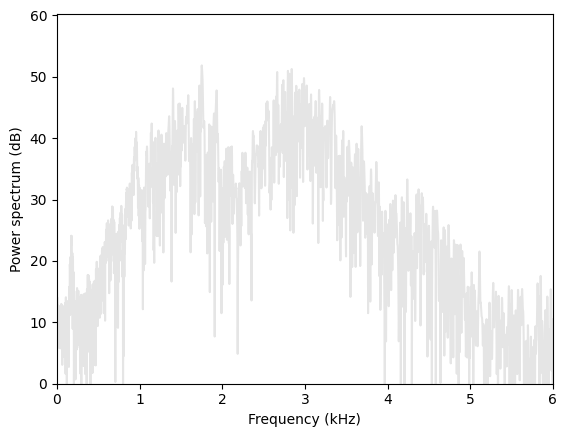

In [ ]:
from scipy.io import wavfile # scipy library to read wav files
import numpy as np
i=0
AudioName = '/content/drive/MyDrive/Borradores_resubmit_sueños/Synthetic_song/sintetico_dia_0.wav'.format(i) # Audio File
fs, Audiodata = wavfile.read(AudioName)

# Plot the audio signal in time
import matplotlib.pyplot as plt
#plt.plot(Audiodata)
#plt.title('Audio signal in time',size=16)

# spectrum
from scipy.fftpack import fft # fourier transform
n = len(Audiodata)
AudioFreq = fft(Audiodata)
AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(n)
# power spectrum
MagFreq = MagFreq**2
if n % 2 > 0: # ffte odd
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq),alpha=0.1,color='k') #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');
plt.xlim(0, 6)
plt.ylim(0,)

Spectrum=np.asarray((MagFreq))
np.savetxt('/content/drive/MyDrive/Borradores_resubmit_sueños/Spectra_song/spectrum_sintetico_dia_{}.txt'.format(i), Spectrum)

In [1]:
-0.061/0.67

-0.09104477611940298